In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch 
import matplotlib.pyplot as plt

## Callbacks

### Callbacks as GUI events

In [3]:
import ipywidgets as widgets

In [4]:
def f(o): print('hi')

In [5]:
w = widgets.Button(description='Click me')

In [6]:
w.on_click(f)

In [7]:
w

Button(description='Click me', style=ButtonStyle())

hi
hi
hi


### Creating your own Callback

In [8]:
from time import sleep

In [9]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i * i
        sleep(1)
    return res

In [10]:
slow_calculation()

30

In [11]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i * i
        sleep(1)
        if cb: cb(i)
    return res

In [12]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [13]:
slow_calculation(cb=show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

### Lambda and partials

In [14]:
slow_calculation(cb=lambda epoch: print(f"Awesome! We've finished epoch {epoch}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [15]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}!")

In [16]:
slow_calculation(lambda o: show_progress("OK I guess", o))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

In [17]:
def make_show_progress(exclamation):
    def _inner(epoch): print(f"{exclamation}! We've finisehd epoch {epoch}!")
    return _inner

In [18]:
slow_calculation(cb=make_show_progress("Nice!"))

Nice!! We've finisehd epoch 0!
Nice!! We've finisehd epoch 1!
Nice!! We've finisehd epoch 2!
Nice!! We've finisehd epoch 3!
Nice!! We've finisehd epoch 4!


30

In [19]:
f2 = make_show_progress("Brill!")

In [28]:
slow_calculation(cb=f2)

Brill!! We've finisehd epoch 0!
Brill!! We've finisehd epoch 1!
Brill!! We've finisehd epoch 2!
Brill!! We've finisehd epoch 3!
Brill!! We've finisehd epoch 4!


30

### Callbacks as callable classes

In [20]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"):
        self.exclamation = exclamation
    def __call__(self, epoch):
        print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [21]:
cb = ProgressShowingCallback("Just super")

In [31]:
slow_calculation(cb)

Just super! We've finished epoch 0!
Just super! We've finished epoch 1!
Just super! We've finished epoch 2!
Just super! We've finished epoch 3!
Just super! We've finished epoch 4!


30

### Multiple Callback funcs; `*args` and `**kwargs`

In [22]:
def f(*args, **kwargs): print(f"args: {args}; kwargs: {kwargs}")

In [23]:
f(3, 'a', thing1='hello')

args: (3, 'a'); kwargs: {'thing1': 'hello'}


In [24]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i * i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [25]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print('About to start')
    def after_calc(self, *args, **kwargs): print('Done step')

In [36]:
slow_calculation(cb=PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [26]:
class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs):
        print(f"About to start: {epoch}")
    def after_calc(self, epoch, val, **kwargs):
        print(f"After {epoch}: {val}")

In [38]:
slow_calculation(cb=PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

### Modifying behaviour

In [27]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'): cb.before_calc(i)
        res += i * i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'): 
            if cb.after_calc(i, res):
                print("stopping early")
                break
    return res        

In [28]:
class PrintAfterCallback():
    def __init__(self): pass
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val > 10: return True

In [29]:
slow_calculation(cb=PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [30]:
class SlowCalculator():
    def __init__(self, cb=None): 
        self.cb, self.res = cb, 0.
        
    def callback(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb, cb_name, None)
        if cb: return cb(self, *args)
    
    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i * i
            sleep(1)
            if self.callback('after_calc', i):
                print("stopping early")
                break

In [39]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res > 10: return True
        if calc.res < 3: calc.res *= 2

In [40]:
calculator = SlowCalculator(cb=ModifyingCallback())

In [41]:
calculator.calc()

After 0: 0.0
After 1: 1.0
After 2: 6.0
After 3: 15.0
stopping early


In [43]:
calculator.res

15.0

## `__dunder__` thingies

In [44]:
class SloppyAdder():
    def __init__(self, o): self.o = o
    def __add__(self, b): return SloppyAdder(self.o + b.o + 0.01)
    def __repr(self): return str(self.o)

In [49]:
a = SloppyAdder(1)
b = SloppyAdder(2)

## Variance and stuff

### Variance

In [52]:
t = torch.tensor([1, 2, 4., 18])

In [54]:
m = t.mean(); m

tensor(6.2500)

In [55]:
(t - m).mean()

tensor(0.)

In [56]:
(t - m).pow(2).mean()

tensor(47.1875)

In [57]:
(t - m).abs().mean()

tensor(5.8750)

In [58]:
(t - m).pow(2).mean().sqrt()

tensor(6.8693)

In [84]:
(t - m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

$$
\begin{align}
\operatorname{Var}(X) &= \operatorname{E}\left[(X - \operatorname{E}[X])^2\right] \\[4pt]
&= \operatorname{E}\left[X^2 - 2X\operatorname{E}[X] + \operatorname{E}[X]^2\right] \\[4pt]
&= \operatorname{E}\left[X^2\right] - 2\operatorname{E}[X]\operatorname{E}[X] + \operatorname{E}[X]^2 \\[4pt]
&= \operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2
\end{align}
$$

### Covariance and correlation

In [62]:
t

tensor([ 1.,  2.,  4., 18.])

In [64]:
u = 2 * t
u *= torch.randn_like(u) / 10 + 0.95

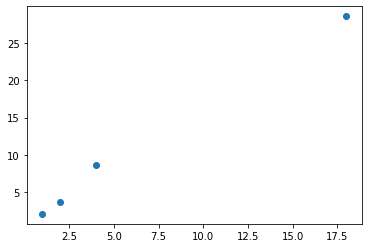

In [66]:
plt.scatter(t, u);

In [68]:
prod = (t - t.mean())*(u - u.mean()); prod

tensor([ 45.2774,  30.1114,   4.7904, 209.6005])

In [69]:
prod.mean()

tensor(72.4449)

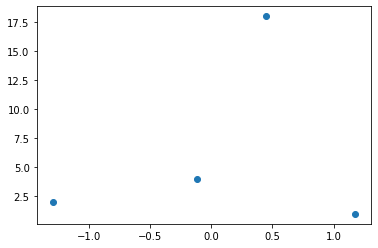

In [71]:
v = torch.randn_like(t)
plt.scatter(v, t);

In [75]:
((v - v.mean()) * (t - t.mean())).mean()

tensor(1.2170)

In [76]:
(v*t).mean() - v.mean()*t.mean()

tensor(1.2170)

In [83]:
((v*t).mean() - v.mean()*t.mean()) / ((v*v).mean() - v.mean()*v.mean()).sqrt() / ((t*t).mean() - t.mean()*t.mean()).sqrt()

tensor(1.2170)

In [82]:
((v*t).mean() - v.mean()*t.mean()) / t.std() / v.std()

tensor(1.2170)

In [86]:
t.std(), ((t*t).mean() - t.mean()*t.mean()).sqrt()

(tensor(7.9320), tensor(6.8693))

In [103]:
(t - t.mean()).pow(2).mean().sqrt() / t.std()

tensor(0.8660)

In [116]:
t1 = torch.randn(10); t1

tensor([-1.3635, -1.2272, -0.2547,  1.5825,  0.4095, -0.0912,  1.4056, -0.1648,
         1.6379,  0.4553])

In [127]:
((t1*t1).mean() - t1.mean()*t1.mean()) / t1.std(unbiased=False)

tensor(1.0214)

In [131]:
t1.std(unbiased=False)

tensor(1.0214)

# fin